<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

# _*Quantum State Tomography of Cat States*_ 

***
### Contributors
Christopher J. Wood [(cjwood@us.ibm.com)](mailto:cjwood@us.ibm.com)

## Introduction

This notebook includes several examples of performing tomography of multi-qubit entangled states. Just as we demonstate in the [state-tomography](state-tomography.ipynb) workbook, where as an example we performed state tomography of a 2-qubit Bell-state, we can generate entangled states across all 5 qubits on the IBM QX. We now demonstrate the tomographic reconstruction using both the local qasm simulator and IBM QX device for entangled states on 3 to 5 qubits. We will consider the *cat-states* which can be thought of as a generalization of the Bell-state to n-qubits. The n-qubit cat state is defined as:
$|\mbox{cat}_n \rangle = \frac{1}{\sqrt2}\left(
    |0^{\otimes n} \rangle
    + |1^{\otimes n} \rangle
    \right)$. For $n=3$ this is more commonly called the GHZ state.

## Getting Started
Please see [Getting Started with QISKit](tutorial4developer.ipynb) if you would like to understand how to get started with the QISKit SDK.

In [1]:
# Checking the version of PYTHON; we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
    
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append("../../")
# importing the QISKit
from qiskit import QuantumProgram
import Qconfig

# import state tomography functions
from statetomo import *

# function using QuTip to visualize density matrices
import qutip as qt  
def plot_state(rho, fidelity=None):
    # plot real part of rho
    fig1, ax = qt.matrix_histogram(rho.real, limits=[-1,1])
    ax.view_init(azim=-55, elev=45)
    # Set fidelity as plot label
    if fidelity != None:
        # Fidelity to 4 decimal places
        ax.set_title("F = %.4f" %fidelity)
    # Plot imaginary part
    fig2, ax = qt.matrix_histogram(rho.imag, limits=[-1,1])
    ax.view_init(azim=-55, elev=45)
    # display plot
    plt.show()

---
## Tomography of GHZ state (n=3)

### Simulation on the local simulator

We now prepare the encoding circuit for a GHZ state. This is done by using the encoding circuit for the Bell-state to entangle the first two qubits, followed by a CNOT between the 2nd and 3rd qubit to prepare the GHZ state. The QASM circuit is :
```
h qr[0];
cx qr[0], qr[1];
cx qr[1], qr[2];
```

In [5]:
QP_ghz_sim = QuantumProgram()
nq = 3
qr = QP_ghz_sim.create_quantum_registers("qr", nq)
cr = QP_ghz_sim.create_classical_registers("cr", nq)
prep = QP_ghz_sim.create_circuit("prep", ["qr"], ["cr"])
prep.h(qr[0])
prep.cx(qr[0], qr[1])
prep.cx(qr[1], qr[2])

>> quantum_registers created: qr 3
>> classical_registers created: cr 3


Next we prepare the tomography measurement circuits, and run the experiment on the local simulator

In [6]:
# build measurement circuits
build_tomo_circuits(QP_ghz_sim, "prep", "qr", "cr", range(nq))
# measurement circuit labels
circuits_ghz = build_tomo_keys("prep", range(nq))

# simulate tomography experiment
device = 'local_qasm_simulator'
shots = 1000
max_credits = 20
result = QP_ghz_sim.execute(circuits_ghz, device, shots, max_credits, wait=20, timeout=600)
print(result)

running on backend: local_qasm_simulator
{'status': 'COMPLETED', 'result': 'all done'}


Next we reconstruct density matrix from the simulated experiment data and compute the fidelity of the reconstructed state.

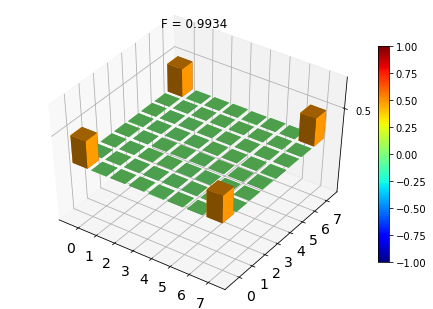

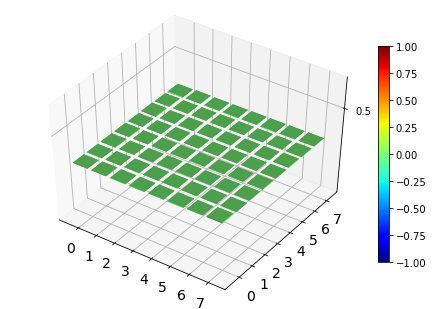

In [7]:
rho_ghz_sim = state_tomography(QP_ghz_sim, circuits_ghz, shots, nq, range(nq))
target_ghz = np.array([1., 0., 0., 0., 0., 0., 0., 1.]/np.sqrt(2.))
F_ghz_sim = fidelity(rho_ghz_sim, target_ghz)
plot_state(rho_ghz_sim, F_ghz_sim)

### Real experiment on the IBM Quantum Experience

Now that we have checked that our experiment works on the simulator, we run it on the real device

In [97]:
# initialize a new program for the real experiment
QP_ghz_real = QuantumProgram()
nq = 3
qr = QP_ghz_real.create_quantum_registers("qr", nq)
cr = QP_ghz_real.create_classical_registers("cr", nq)
prep = QP_ghz_real.create_circuit("prep", ["qr"], ["cr"])
prep.h(qr[0])
prep.cx(qr[0], qr[1])
prep.cx(qr[1], qr[2])

# build tomography circuits
build_tomo_circuits(QP_ghz_real, "prep", "qr", "cr", range(nq))
circuits_ghz = build_tomo_keys("prep", range(nq))

# run experiment on the IBM QX
device = 'ibmqx2'
shots = 500
max_credits = 20
QP_ghz_real.set_api(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url
result = QP_ghz_real.execute(circuits_ghz, device, shots, max_credits, wait=20, timeout=600)
print(result)

>> quantum_registers created: qr 3
>> classical_registers created: cr 3
running on backend: ibmqx2
status = RUNNING (20 seconds)
status = RUNNING (40 seconds)
{'status': 'COMPLETED', 'result': 'all done'}


Reconstruct density matrix and plot result

F = 0.84911


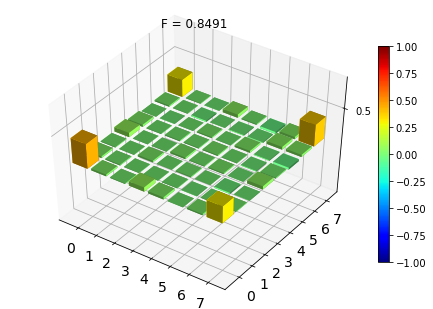

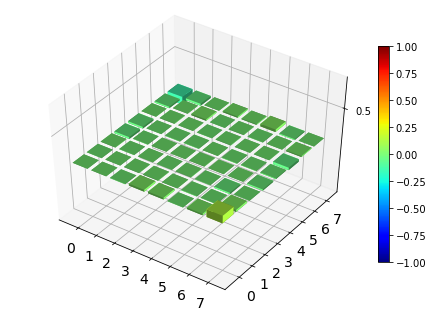

In [98]:
rho_ghz_real = state_tomography(QP_ghz_real, circuits_ghz, shots, 5, range(nq))
F_ghz_real =fidelity(rho_ghz_real, target_ghz)
print("F = %.5f" % F_ghz_real)
plot_state(rho_ghz_real, F_ghz_real)

### Challenge

A common source of error in experiments are phase-errors on qubits during CNOT gates. See if you can improve the fidelity of the GHZ state by inserting $u1(\lambda)$ rotations into the encoding circuit to correct these phase errors.

---
## Tomography of 4-qubit cat-state

We now prepare the encoding circuit for a 4-qubit cat-state. As with the GHZ state, we prepare this by using the encoding circuit of the cat state on one less qubit (GHZ state in this case), and adding an additonal CNOT gate to the additional qubit:
```
h qr[0];
cx qr[0], qr[1];
cx qr[1], qr[2];
cx qr[2], qr[3];
```
There is a problem with this circuit however, on the IBM QX we can't directly do a CNOT gate with `qr[2]` as control, and `qr[3]` as target. We can however do it with the control and targets reversed, so we must replace this gate with a logically equivalent one: 
```
h qr[0];
cx qr[0], qr[1];
cx qr[1], qr[2];
h qr[2]; h qr[3];
cx qr[3], qr[2];
h qr[2]; h qr[3];
```

### Simulation on the local simulator

In [175]:
QP_cat4_sim = QuantumProgram()
nq = 4
qr = QP_cat4_sim.create_quantum_registers("qr", nq)
cr = QP_cat4_sim.create_classical_registers("cr", nq)
prep = QP_cat4_sim.create_circuit("prep", ["qr"], ["cr"])
prep.h(qr[0])
prep.cx(qr[0], qr[1])
prep.cx(qr[1], qr[2])
# can't do cx[2,3] on QuantumExperience, need to do h[2,3] cx[3,2] h[2,3]
prep.h(qr[2])
prep.h(qr[3])
prep.cx(qr[3], qr[2])
prep.h(qr[2])
prep.h(qr[3])
build_tomo_circuits(QP_cat4_sim, "prep", "qr", "cr", range(nq))
circuits_cat4 = build_tomo_keys("prep", range(nq))

device = 'local_qasm_simulator'
shots = 250
max_credits = 20
result = QP_cat4_sim.execute(circuits_cat4, device, shots, max_credits, wait=20, timeout=600)
print(result)

>> quantum_registers created: qr 4
>> classical_registers created: cr 4
running on backend: local_qasm_simulator
{'status': 'COMPLETED', 'result': 'all done'}


Reconstruct density matrix and compute fidelity

In [176]:
rho_cat4_sim = state_tomography(QP_cat4_sim, circuits_cat4, shots, nq, range(nq))
target_cat4 = np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]/np.sqrt(2.))
F_cat4_sim = fidelity(rho_cat4_sim, target_cat4)
print("F = %.5f" % F_cat4_sim)

Using wizard method to constrain positivity
F = 0.99764


Plot the reconstructed matrix

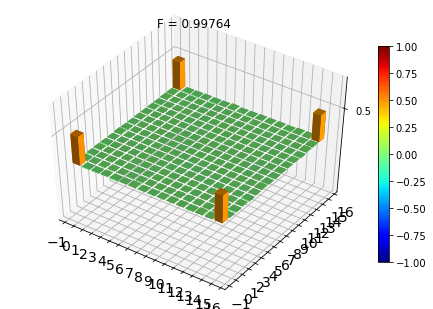

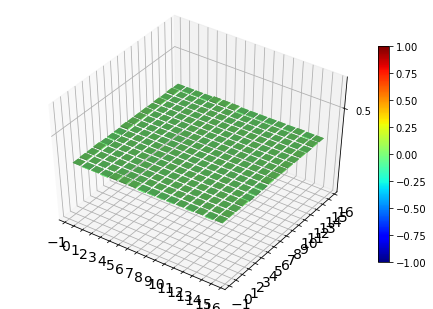

In [177]:
plot_state(rho_cat4_sim, F_cat4_sim)

### Real experiment on the IBM Quantum Experience

Now we prepare to run the experiment on the IBM QX 

In [178]:
QP_cat4_real = QuantumProgram()
nq = 4
qr = QP_cat4_real.create_quantum_registers("qr", nq)
cr = QP_cat4_real.create_classical_registers("cr", nq)
prep = QP_cat4_real.create_circuit("prep", ["qr"], ["cr"])
prep.h(qr[0])
prep.cx(qr[0], qr[1])
prep.cx(qr[1], qr[2])
# can't do cx[2,3] on QuantumExperience, need to do h[2,3] cx[3,2] h[2,3]
prep.h(qr[2])
prep.h(qr[3])
prep.cx(qr[3], qr[2])
prep.h(qr[2])
prep.h(qr[3])

build_tomo_circuits(QP_cat4_real, "prep", "qr", "cr", range(nq))
circuits_cat4 = build_tomo_keys("prep", range(nq))

>> quantum_registers created: qr 4
>> classical_registers created: cr 4


We note here that due to the larger number of measurement circuits (81) we only do 100 shots per experiment to keep the run time low. Also since we have too many circuits to submit in a single batch to the QX we must break this up into several smaller jobs where we will only run 20 circuits at a time.

In [179]:
device = 'ibmqx2'
shots = 100
max_credits = 20
QP_cat4_real.set_api(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url
result1 = QP_cat4_real.execute(circuits_cat4[0:20], device, shots, max_credits, wait=20, timeout=300)
result2 = QP_cat4_real.execute(circuits_cat4[20:40], device, shots, max_credits, wait=20, timeout=300)
result3 = QP_cat4_real.execute(circuits_cat4[40:60], device, shots, max_credits, wait=20, timeout=300)
result4 = QP_cat4_real.execute(circuits_cat4[60:81], device, shots, max_credits, wait=20, timeout=300)
print(result1)
print(result2)
print(result3)
print(result4)

running on backend: ibmqx2
status = RUNNING (20 seconds)
running on backend: ibmqx2
status = RUNNING (20 seconds)
running on backend: ibmqx2
status = RUNNING (20 seconds)
running on backend: ibmqx2
status = RUNNING (20 seconds)
{'status': 'COMPLETED', 'result': 'all done'}


Reconstruct density matrix and plot result

In [181]:
rho_cat4_real = state_tomography(QP_cat4_real, circuits_cat4, shots_sim, 5, range(nq))
F_cat4_real = fidelity(rho_cat4_real, target_cat4)
print("F = %.5f" % F_cat4_real)

Using wizard method to constrain positivity
F = 0.85647


Plot the reconstructed matrix

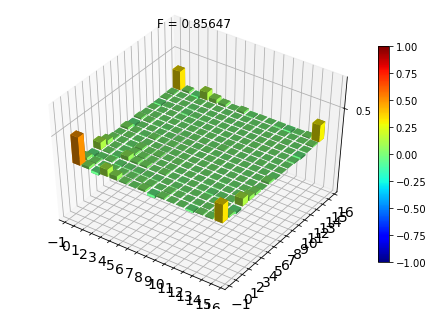

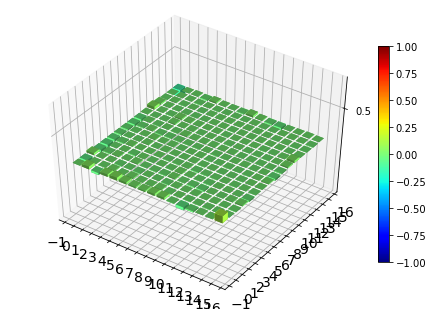

In [182]:
plot_state(rho_cat4_sim, F_cat4_sim)

---
## Tomography of 5-qubit cat-state

Finally let us prepare and measure a 5-qubit cat-state. In this case the encoding cirucit is
```
h qr[0];
cx qr[0], qr[1];
cx qr[1], qr[2];
h qr[2]; h qr[3];
cx qr[3], qr[2];
h qr[2]; h qr[3];
cx qr[3], qr[4];
```

### Simulation on the local simulator

In [183]:
QP_cat5_sim = QuantumProgram()
nq = 5
qr = QP_cat5_sim.create_quantum_registers("qr", nq)
cr = QP_cat5_sim.create_classical_registers("cr", nq)
prep = QP_cat5_sim.create_circuit("prep", ["qr"], ["cr"])
prep.h(qr[0])
prep.cx(qr[0], qr[1])
prep.cx(qr[1], qr[2])
# can't do cx[2,3] on QuantumExperience, need to do h[2,3] cx[3,2] h[2,3]
prep.h(qr[2])
prep.h(qr[3])
prep.cx(qr[3], qr[2])
prep.h(qr[2])
prep.h(qr[3])
prep.cx(qr[3], qr[4])
build_tomo_circuits(QP_cat5_sim, "prep", "qr", "cr", range(nq))
circuits_cat5 = build_tomo_keys("prep", range(nq))

device = 'local_qasm_simulator'
shots = 250
max_credits = 20
result = QP_cat5_sim.execute(circuits_cat5, device, shots, max_credits, wait=20, timeout=600)
print(result)

>> quantum_registers created: qr 5
>> classical_registers created: cr 5
running on backend: local_qasm_simulator
{'status': 'COMPLETED', 'result': 'all done'}


Reconstruct density matrix and compute fidelity

In [184]:
rho_cat5_sim = state_tomography(QP_cat5_sim, circuits_cat5, shots, nq, range(nq))
target_cat5 = np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]/np.sqrt(2.))
F_cat5_sim = fidelity(rho_cat5_sim, target_cat5)
print("F = %.5f" % F_cat5_sim)

Using wizard method to constrain positivity
F = 0.99299


Plot the reconstructed matrix

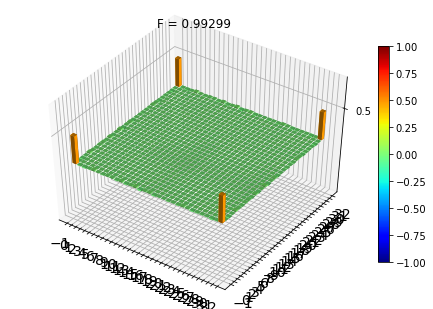

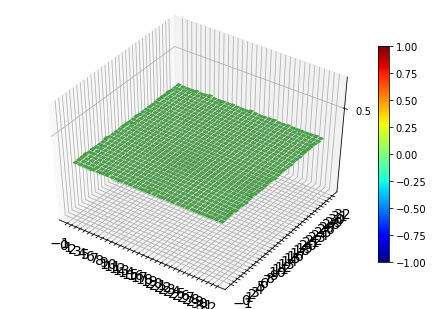

In [185]:
plot_state(rho_cat5_sim, F_cat5_sim)

### Real experiment on the IBM Quantum Experience

In [189]:
QP_cat5_real = QuantumProgram()
nq = 5
qr = QP_cat5_real.create_quantum_registers("qr", nq)
cr = QP_cat5_real.create_classical_registers("cr", nq)
prep = QP_cat5_real.create_circuit("prep", ["qr"], ["cr"])
prep.h(qr[0])
prep.cx(qr[0], qr[1])
prep.cx(qr[1], qr[2])
# can't do cx[2,3] on QuantumExperience, need to do h[2,3] cx[3,2] h[2,3]
prep.h(qr[2])
prep.h(qr[3])
prep.cx(qr[3], qr[2])
prep.h(qr[2])
prep.h(qr[3])
prep.cx(qr[3], qr[4])

build_tomo_circuits(QP_cat5_real, "prep", "qr", "cr", range(nq))
circuits_cat5 = build_tomo_keys("prep", range(nq))

>> quantum_registers created: qr 5
>> classical_registers created: cr 5


In [190]:
device = 'ibmqx2'
shots = 100
max_credits = 10
QP_cat5_real.set_api(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url
result1 = QP_cat5_real.execute(circuits_cat5[0:50], device, shots, max_credits, wait=20, timeout=300)
result2 = QP_cat5_real.execute(circuits_cat5[50:100], device, shots, max_credits, wait=20, timeout=300)
result3 = QP_cat5_real.execute(circuits_cat5[100:150], device, shots, max_credits, wait=20, timeout=300)
result4 = QP_cat5_real.execute(circuits_cat5[150:200], device, shots, max_credits, wait=20, timeout=300)
result5 = QP_cat5_real.execute(circuits_cat5[200:243], device, shots, max_credits, wait=20, timeout=300)

print(result1)
print(result2)
print(result3)
print(result4)
print(result5)

running on backend: ibmqx2
status = RUNNING (20 seconds)
status = RUNNING (40 seconds)
running on backend: ibmqx2
status = RUNNING (20 seconds)
status = RUNNING (40 seconds)
running on backend: ibmqx2
status = RUNNING (20 seconds)
status = RUNNING (40 seconds)
running on backend: ibmqx2
status = RUNNING (20 seconds)
status = RUNNING (40 seconds)
running on backend: ibmqx2
status = RUNNING (20 seconds)
status = RUNNING (40 seconds)
{'status': 'COMPLETED', 'result': 'all done'}
{'status': 'COMPLETED', 'result': 'all done'}
{'status': 'COMPLETED', 'result': 'all done'}
{'status': 'COMPLETED', 'result': 'all done'}
{'status': 'COMPLETED', 'result': 'all done'}


Reconstruct density matrix and plot result

In [192]:
rho_cat5_real = state_tomography(QP_cat5_real, circuits_cat5, shots_sim, 5, range(nq))
F_cat5_real = fidelity(rho_cat5_real, target_cat5)
print("F = %.5f" % F_cat5_real)

Using wizard method to constrain positivity
F = 0.75419


Plot the reconstructed matrix

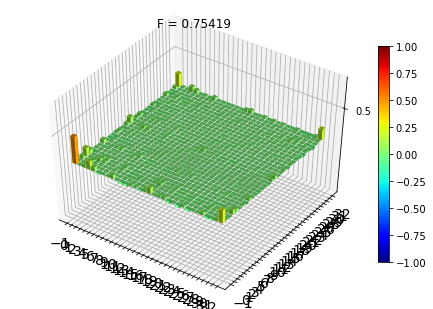

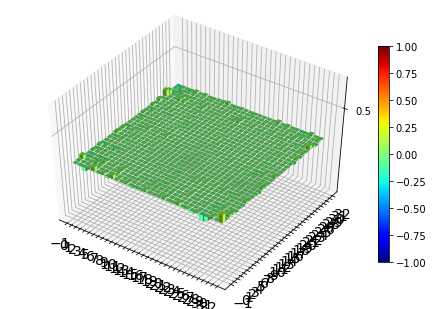

In [193]:
plot_state(rho_cat5_real, F_cat5_real)